# 머신러닝 맛보기 2편

__참고:__ 조엘 그루스의 [<밑바닥부터 시작하는 데이터과학(2판)>](https://github.com/joelgrus/data-science-from-scratch)에 포함된 
[Gradient Descent](https://github.com/joelgrus/data-science-from-scratch/blob/master/scratch/gradient_descent.py)의 소스코드 일부를 사용합니다.

## 주요 내용

1. 경사하강법 의미
1. 그레이디언트 계산
1. 경사하강법으로 최솟점 구하기
1. 경사하강법과 선형회귀

## 기본 설정

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [1]:
import numpy as np

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

### 주의사항

연습문제를 제외한 본문은 넘파이를 전혀 사용하지 않는다.

## 준비사항

선형대수에서 정의한 함수를 사용하기 위한 준비가 필요하며
필요한 코드가 `pydata06_linear_algebra_basics.py` 파일에 저장되어 있다고 가정한다.

먼저 파일을 다운로드한다. 

In [2]:
import urllib.request

file_url = "https://raw.githubusercontent.com/codingalzi/pydata/master/notebooks/pydata06_linear_algebra_basics.py"
file_name = "pydata06_linear_algebra_basics.py"
urllib.request.urlretrieve(file_url, file_name)

('pydata06_linear_algebra_basics.py',
 <http.client.HTTPMessage at 0x7fae25084610>)

In [3]:
import pydata06_linear_algebra_basics as LA

## 1. 경사하강법

주어진 데이터셋을 가장 잘 반영하는 최적의 수학적 모델을 찾으려 할 때 가장 기본적으로 사용되는 기법이
**경사하강법**(gradient descent)이다.
최적의 모델에 대한 기준은 학습법에 따라 다르지만, 
보통 학습된 모델의 오류를 최소화하도록 유도하는 기준을 사용한다. 

여기서는 선형회귀 모델을 학습하는 데에 기본적으로 사용되는 **평균 제곱 오차**(mean squared error, MSE)를
최소화하기 위해 경사하강법을 적용하는 과정을 살펴본다.

### 경사하강법 기본 아이디어

함수 $f:\mathbf{R}^n \to \mathbf{R}$의 최솟값 지점을 구하고자 한다.
예를 들어, 
길이가 $n$인 실수 벡터를 입력받아 항목들의 제곱의 합을 계산하는 함수가 다음과 같다고 하자.

$$
f(\mathbf v) = f(v_1, ..., v_n) = \sum_{k=1}^{n} v_k^2 = v_1^2 + \cdots v_n^2
$$

아래 코드에서 정의된 `sum_of_squares()`가 위 함수를 파이썬으로 구현한다.

__참고:__ `LA.Vector` 는 `typing.List[float]`, 즉 부동소수점들의 리스트 자료형을 가리킴.

In [4]:
def sum_of_squares(v: LA.Vector) -> float:
    """
    v 벡터에 포함된 원소들의 제곱의 합 계산
    """
    return LA.dot(v, v)

이제 `sum_of_squares(v)`가 최대 또는 최소가 되는 벡터 `v`를 찾고자 한다.

그런데 특정 함수의 최솟값이 존재한다는 것이 알려졌다 하더라도 실제로 최솟값
지점을 확인하는 일은 일반적으로 매우 어렵고, 경우에 따라 불가능하다. 
따라서 보통 해당 함수의 그래프 위에 존재하는 임의의 점에서 시작한 후
그레이디언트 반대 방향으로 조금씩 이동하면서 최솟값 지점을 찾아가는
**경사하강법**(gradient descent)을 이용한다.

#### 그레이디언트의 정의와 의미

함수 $f:\mathbf{R}^n \to \mathbf{R}$가 점 $\mathbf{v}\in \mathbf{R}^n$에서 
미분 가능할 때 $\mathbf{v}$에서 $f$의 __그레이디언트__는 다음처럼 편미분으로 이루어진 벡터로 정의된다. 

$$
\nabla f(\mathbf{v}) =
\begin{bmatrix}
    \frac{\partial}{\partial v_1} f(\mathbf{v}) \\
    \vdots \\
    \frac{\partial}{\partial v_n} f(\mathbf{v})
\end{bmatrix}
$$

아래에서 왼편 그림은 $n=1$인 경우 2차원 상에서, 오른편 그림은 $n=2$인 경우에 3차원 상에서 
그려지는 함수의 그래프와 특정 지점에서의 
그레이디언트를 보여주고 있다. 

* 왼편 그림
    * 그레이디언트는 접선(tangent line)의 기울기(slope)를 가리키는 미분값 $f'(x)$이다.
    * 갈색 직선이 접선을 가리킨다.
* 오른편 그림
    * 그레이디언트는 편미분값으로 구성된 길이가 2인 벡터
        $\left( \frac{\partial}{\partial v_1} f(\mathbf{v}), \frac{\partial}{\partial v_2} f(\mathbf{v}) \right)$ 로 계산되며, 위쪽으로 향하는 파란색 화살표로 표시된다.
    * 파란색 초평면(hyperplane)은 해당 지점에서 그래프와 접하는 평면을 보여준다. 

<table>
    <tr>
        <td>
            <img src="https://raw.githubusercontent.com/codingalzi/pydata/master/notebooks/images/Tangent-line.png" alt="경사하강법">
        </td>
        <td>
            <img src="https://raw.githubusercontent.com/codingalzi/pydata/master/notebooks/images/tangent_space-90.png" alt="경사하강법">
        </td>
    </tr>
    <tr>
        <td>
            &#60;출처	&#62; <a href="https://en.wikipedia.org/wiki/Derivative">위키:미분</a>
        </td>
        <td>
            &#60;출처	&#62; <a href=""https://github.com/pvigier/gradient-descent>pvigier: gradient-descent </a>
        </td>
    </tr>
</table>

#### 경사하강법 작동 방식

경사하강법은 다음 과정을 반복하여 최솟값 지점을 찾아가는 것을 의미한다. 

* 해당 지점에서 그레이디언트(gradient)를 계산한다.
* 계산된 그레이디언트의 방향(반대방향)으로 그레이디언트 크기의 일정 비율만큼 이동한다. 

아래 그림은 2차원 함수의 최솟값 지점을 경사하강법으로 찾아가는 과정을 보여준다.
최솟값 지점은 해당 지점에서 구한 그레이디언트의 반대방향으로 조금씩 이동하는 방식으로 이루어진다. 

최솟값 지점에 가까워질 수록 그레이디언트는 점점 0벡터에 가까워진다. 
따라서 그레이디언트가 충분히 작아지면 최솟값 지점에 매우 가깞다고 판단하여 그 위치에서
최솟값 지점의 근사치를 구하여 활용할 수 있다.

<img src="https://raw.githubusercontent.com/codingalzi/pydata/master/notebooks/images/Gradient-Descent.gif" alt="경사하강법">
&#60;출처	&#62; <a href=""https://github.com/pvigier/gradient-descent>pvigier: gradient-descent </a>

#### 주의사항

경사하강법은 지역 최솟값(local minimum)이 없고 전역 최솟값(global mininum)이 존재할 경우 유용하게 활용된다.
반면에 지역 최솟값이 존재할 경우 제대로 작동하지 않을 수 있기 때문에 많은 주의를 요한다. 
아래 그림은 출발점과 이동 방향에 따라 도착 지점이 전역 또는 지역 최솟점이 될 수 있음을 잘 보여준다.
하지만 이런 경우는 여기서 다루지 않는다.

<img src="https://raw.githubusercontent.com/codingalzi/pydata/master/notebooks/images/Gradient.png" alt="경사하강법">
&#60;출처	&#62; <a href="https://en.wikipedia.org/wiki/Derivative">위키:미분</a>

## 2. 파이썬으로 그레이디언트 계산

단변수 함수와 다변수 함수의 경우 그레이디언트 계산이 조금 다르다. 

### 단변수 함수의 도함수 계산

$f$가 단변수 함수(1차원 함수)일 때, 점 $x$에서의 그레이디언트는 다음과 같이 구한다. 

$$
f'(x) = \lim_{h\to 0} \frac{f(x+h) - f(x)}{h}
$$

즉, $f'(x)$ 는 $x$가 아주 조금 변할 때 $f(x)$가 변하는 정도, 즉
함수 $f$의 $x$에서의 **미분값**이 된다.
이때 함수 $f'$ 을 함수 $f$의 **도함수**라 부른다.

예를 들어, 제곱 함수 $f(x) = x^2$에 해당하는 `square()`가 아래와 같이 주어졌다고 하자.

In [5]:
def square(x: float) -> float:
    return x * x

그러면 $f$의 도함수 $f'(x) = 2x$는 아래 `square_prime()` 함수로 구현된다.

In [6]:
def square_prime(x: float) -> float:
    return 2 * x

#### 도함수 근사치

이와 같이 미분함수가 구체적으로 주어지는 경우는 일반적이지 않다.
따라서 여기서는 충분히 작은 $h$에 대한 함수의 변화율

$$
\frac{f(x+h) - f(x)}{h}
$$

을 측정하여
미분값의 근사치로 사용한다.

아래 그림은 $h$가 작아질 때 
두 점 $f(x+h)$ 와 $f(x)$ 지나는 직선이 변하는 과정을 보여준다.
$h$가 0에 수렴하면 최종적으로 점 $x$에서의 접선이 되고
미분값 $f'(x)$는 접선의 기울기가 된다. 

<img src="https://raw.githubusercontent.com/codingalzi/pydata/master/notebooks/images/Derivative.gif" alt="경사하강법">
&#60;출처	&#62; <a href="https://en.wikipedia.org/wiki/Derivative">위키:미분</a>

아래 코드는 임의의 단변수 함수에 대해 함수 변화율을 구해주는 함수를 간단하게 구현한 것이다.
          
* `Callable`은 함수에 대한 자료형을 가리킨다. 
    * `Callable[[float], float]`: 부동소수점을 하나 받아 부동소수점을 계산하는 함수들의 클래스를 가리킴.
* `different_quotient()` 함수가 사용하는 세 인자와 리턴값의 자료형은 다음과 같다. 
    * 미분 대상 함수: `f: Callable[[float], float]`
    * 미분 위치: `x: float`
    * 인자가 변하는 정도: `h: float`
    * 리턴값(`float`): $f'(x)$의 근사치

In [7]:
from typing import Callable

def difference_quotient(f: Callable[[float], float],
                        x: float,
                        h: float) -> float:
    """
    함수 f의 x에서의 미분값 근사치 계산
    f: 미분 대상 함수
    x: 인자
    h: x가 변하는 정도
    """
    
    return (f(x + h) - f(x)) / h

아래 코드는 `square()`의 도함수 `square_prime()` 을 `difference_quotient()`를 
이용하여 충분히 근사적으로 구현할 수 있음을 보여준다. 
근사치 계산을 위해 `h=0.001` 를 사용한다.

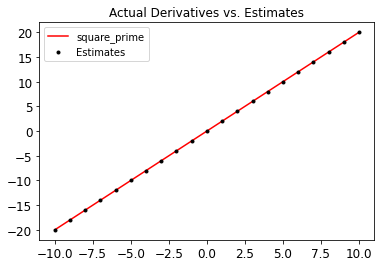

In [8]:
h = 0.001
xs = range(-10, 11)

actuals = [square_prime(x) for x in xs]
estimates = [difference_quotient(square, x, h) for x in xs]

plt.title("Actual Derivatives vs. Estimates")

# 실제 도함수 그래프(빨간색 직선)
plt.plot(xs, actuals, 'r-', label='square_prime') 

# 근사치 그래프(검은색 점)
plt.plot(xs, estimates, 'k.', label='Estimates')
plt.legend()
plt.show()

### 다변수 함수의 그레이디언트 계산

다변수 함수의 그레이디언트는 매개변수 각가에 대한 **편도함수**(partial derivative)로
구성된 벡터로 구성된다.
예를 들어, $i$번째 편도함수는 $i$번째 매개변수를 제외한 다른 모든 매개변수를 고정하는 
방식으로 계산된다. 

$f$가 다변수 함수(다차원 함수)일 때, 점 $\mathbf{v}$에서의 $i$번째 도함수는 다음과 같다.

$$
\frac{\partial}{\partial v_i}f(\mathbf{v}) = \lim_{h \to 0} \frac{f(\mathbf{v}_{i, h}) - f(\mathbf x)}{h}
$$

여기서 $\mathbf{v}_{i, h}$는 $\mathbf{v}$의 $i$번째 항목에 $h$를 더한 벡터

$$
\mathbf{v}_{i, h} = (v_1, \dots, v_{i-1}, v_i + h, v_{i+1}, \dots, v_n)
$$

를 가리킨다.
즉, $\frac{\partial}{\partial v_i} f(\mathbf{v})$ 는 $v_i$가 아주 조금 변할 때 
$f(\mathbf{v})$가 변하는 정도, 즉
함수 $f$의 $\mathbf{v}$에서의 $i$번째 **편미분값**이 된다.
이때 함수 $\frac{\partial}{\partial v_i}f$ 를 함수 $f$의 $i$번째 **편도함수**라 부른다.

#### 편도함수 근사치

아래 코드에서 정의된 `partial_difference_quotient()`는 주어진 다변수 함수의 $i$번째
편도함수의 근사치를 계산해주는 함수이다.
사용되는 매개변수는 `difference_quotient()` 함수의 경우와 거의 같다.
다만 $i$번째 편도함수의 근사치를 지정하기 위해 $i$번째 매개변수에만 $h$가 더해짐에 주의하라.

In [9]:
def partial_difference_quotient(f: Callable[[LA.Vector], float],
                                v: LA.Vector,
                                i: int,
                                h: float) -> float:
    """
    함수 f의 v에서의 i번째 편미분값 근사치 계산
    f: 편미분 대상 함수
    v: 인자 벡터
    i: i번째 인자를 가리킴
    h: 인자 v_i가 변하는 정도
    """
    
    # v_i에 대해서만 h를 더한 벡터
    w = [v_j + (h if j == i else 0) for j, v_j in enumerate(v)]

    return (f(w) - f(v)) / h    

다음 `estimate_gradient()` 함수는 편미분 근사치를 이용하여 
그레이디언트의 근사치에 해당하는 벡터

$$
\begin{bmatrix}
    \frac{f(\mathbf{v}_{1, h}) - f(\mathbf x)}{h}\\
    \vdots \\
    \frac{f(\mathbf{v}_{n, h}) - f(\mathbf x)}{h}
\end{bmatrix}
$$

를 리스트로 계산한다. 
근사치 계산에 사용된 $h$의 기본값은 0.0001이다.

In [10]:
def estimate_gradient(f: Callable[[LA.Vector], float],
                      v: LA.Vector,
                      h: float = 0.0001):
    
    return [partial_difference_quotient(f, v, i, h) for i in range(len(v))]

__참고:__ 
그레이디언트를 두 개의 함수값의 차이를 이용하여 근사치로 계산하는 방식은 계산 비용이 크다.
벡터 `v`의 길이가 $n$이면 `estimate_gradient()` 함수를 호출할 때마다
`f`를 $2n$ 번 호출해야 하기 때문이다. 
따라서 앞으로는 그레이디언트 함수가 수학적으로 쉽게 계산되는 경우만을 
사용하여 경사하강법의 용도를 살펴볼 것이다.

## 3. 경사하강법으로 최솟점 구하기

앞서 정의한 제곱함수 `sum_of_squares()` 는 `v`가 0 벡터일 때 가장 작은 값을 갖는다. 
이 사실을 경사하강법을 이용하여 확인해보자. 

먼저, `sum_of_squares()` 함수의 그레이디언트는 다음과 같이 정의된다. 

$$
\nabla f(\mathbf{v}) =
\begin{bmatrix}
    2v_1 \\
    \vdots \\
    2v_n
\end{bmatrix}
$$

아래 코드는 리스트를 이용하여 그레이디언트를 구현하였다.

In [11]:
def sum_of_squares_gradient(v: LA.Vector) -> LA.Vector:
    return [2 * v_i for v_i in v]

아래 코드는 임의의 지점(`v`)에서 계산된 그레이디언트에 학습률(learning rate)이라는 특정 상수를 곱한 값을
빼서 새로운 지점을 계산하는 함수를 구현한다.

__참고:__ `subtractV`, `scalar_multV`, `distance` 등은 선형대수 부분에서 정의한 
`pydata06_linear_algebra_basics.py` 모듈에서 가져온다.

In [12]:
import random

def gradient_step(v: LA.Vector, gradient: LA.Vector, learning_rate: float) -> LA.Vector:
    step = LA.scalar_multV(learning_rate, gradient)
    new_V = LA.subtractV(v, step)                    # 그레이디언트의 반대방향으로 이동

    return new_V

이제 임의의 지점에서 출발하여 `gradient_step()` 함수를 충분히 반복하면
제곱함수의 최솟점에 충분히 가깝게 근사할 수 있음을 아래 코드가 보여준다.
실제로 전역 최솟값 위치인 원점에 매우 가깝게 접근한다.

* `random.seed(42)`: 실행할 때마다 동일한 결과를 보장해준다. 사용하지 않으면 매번 다른 결과가 나옴.
* `grad`: 이동할 때마다 계산된 그레이디언트. 최종적으로 0 벡터에 가까운 값을 갖게 됨.
* `if epoch%100 == 0`: 위치 이동을 100번 할 때마다 현재 위치 확인
* `epoch`(에포크): 여기서는 그레이디언트 계산 횟수. 즉, 이동횟수를 가리킴.
* `learning_rate=0.01`: 그레이디언트 반대 방향, 즉, 최솟값 지점을 향해 이동할 때 사용되는 크기 비율

In [13]:
random.seed(42)

# 임의로 선택된 출발점 좌표
v = [random.uniform(-10, 10) for i in range(3)]

# gradient_step 1000번 반복
for epoch in range(1000):
    grad = sum_of_squares_gradient(v)  # 그레이디언트 계산
    
    v = gradient_step(v, grad, 0.01)   # 좌표 업데이트
    
    if epoch%100 == 0:
        print(epoch, v)

print("\n----\n")        
print(f"그레이디언트의 최종 값: {grad}")
print(f"v의 최후 위치와 최솟점 사이의 거리: {LA.distance(v, [0, 0, 0])}")

0 [2.732765249774521, -9.309789197635727, -4.409425359965263]
100 [0.3624181137897112, -1.2346601088642208, -0.5847760329896551]
200 [0.048063729299005625, -0.16374007531854073, -0.07755273779298358]
300 [0.006374190434279768, -0.02171513607091833, -0.010285009644527733]
400 [0.0008453423045827667, -0.002879851701919325, -0.0013639934114305214]
500 [0.00011210892101281368, -0.00038192465375128993, -0.00018089220046728499]
600 [1.4867835316559317e-05, -5.065067796575345e-05, -2.3989843290795995e-05]
700 [1.971765716798422e-06, -6.717270417586384e-06, -3.1815223632100903e-06]
800 [2.6149469369030636e-07, -8.908414196052704e-07, -4.2193208287814765e-07]
900 [3.467931014604295e-08, -1.1814299344070243e-07, -5.5956445449048146e-08]

----

그레이디언트의 최종 값: [9.57758165411209e-09, -3.262822016281278e-08, -1.5453808714914104e-08]
v의 최후 위치와 최솟점 사이의 거리: 1.830234305038648e-08


### 에포크와 학습률

앞서 사용된 코드에서 에포크(epoch)는 이동 횟수를 가리키며, 
에포크를 크게 하면 최솟값 지점에 보다 가까워진다.
하지만 항상 수렴하는 방향으로 이동하는 것은 아니다.
하지만 여기서는 학습률을 너무 크게 지정하지만 않으면 항상 최솟값 지점에 수렴하는 
볼록함수만 다룬다. 
학습률에 따른 수렴속도는 다음과 같다.

* 학습률 크게: 수렴 속도가 빨라진다.
* 학습률 작게: 수렴 속도가 느려진다.

하지만 다루는 함수에 따른 적당한 학습률이 달라지며,
보통 여러 실혐을 통해 정해야 한다.

## 4. 경사하강법과 선형회귀

주어진 데이터들의 분포에 대한 선형회귀 모델의 훈련과정을 구현해보자.

### 훈련 세트 준비

먼저 $y = f(x) = 5 + 20x$ 일차함수의 그래프에 해당하는 데이터를 구한다. 
여기서 $x$ 는 -0.5에서 0.5 사이에 있는 100개의 값으로 주어지며,
$y$ 값에 약간의 잡음(가우시안 잡음)이 추가된다.

In [14]:
# x는 -0.5에서 0.5 사이
X = [x/100 for x in range(-50, 50)]

# 약간의 잡음 추가 (가우시안 잡음)
error = [random.randrange(-100,100)/100 for _ in range(-50, 50)]

# y = 5 + 20*x + 가우시안 잡음
y = [5 + 20*x + e for x, e in zip(X, error)]

# (x,y) 좌표값들의 리스트
inputs = list(zip(X, y))

아래 프로그램은 잡음이 포함되어 직선으로 그려지지 않는 
데이터의 분포를 보여준다.

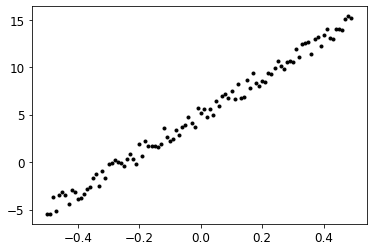

In [15]:
plt.plot(X, y, 'k.')
plt.show()

### 목표

이제 위 그래프를 선형적으로 묘사하는 함수를 경사하강법을 이용하여 구현한다.
즉 아래 1차 함수의 직선 그래프가 위 데이터의 분포를 최적으로 묘사하는 
$\theta_0$와 $\theta_1$을 구해야 한다.

$$
\hat y_x = \theta_0 + \theta_1\cdot x
$$

* $\theta_0$: 절편
* $\theta_1$: 기울기
* $\hat y_x$: $y_x$ 에 대한 예측값

### 비용함수

경사하강법을 적용하려면 최적의 기준을 지정해야 한다. 
여기서는 예측치 $\hat y$와 실제 $y$ 사이의 **평균제곱오차**(mean squared error, MSE)를
최소로 하는 것을 최적의 기준으로 사용한다($m$은 $X$의 원소 개수).

$$
\begin{align*}
\textrm{MSE}(\theta_0, \theta_1) 
&= \frac{1}{m} \sum_{x \in X} (\hat y_x - y_x)^2\\[1ex] 
&= \frac{1}{100}\sum_{x \in X} (\theta_0 + \theta_1\cdot x - y_x)^2
\end{align*}
$$

즉, MSE를 최소로 하는 $\theta_0, \theta_1$을 구해야 한다.
($x, y_x$는 모두 상수임에 주의하라.)
이처럼 최적의 기준으로 최솟값 지점을 찾는 대상인 함수를 __비용함수__라 부른다. 

#### 비용함수의 그레이언트

MSE의 그레이디언트는 다음과 같다.

$$
\nabla \textrm{MSE}(\theta_0, \theta_1)
= 
\frac{1}{100} \cdot
\begin{bmatrix}
\sum_{x \in X} 2(\hat y_x - y_x) \\[1ex]
\sum_{x \in X} 2(\hat y_x - y_x) x
\end{bmatrix}
$$

이처럼 전체 데이터셋을 대상으로 평균제곱오차의 그레이디언트를 활용하는 경사하강법을
__배치 경사하강법__이라 부른다.

### 경사하강법 활용

아래 코드의 `linear_gradient()` 함수는 특정 데이터 샘플 $x$에 대해 타깃(실제값) $y$와 예측치 $\hat y$ 사이의 
MSE 함수의 그레이디언트를 계산한다.

| 변수 | 의미 |
| :--- | :--- |
| intercept | $\theta_0$ (절편) |
| slope | $\theta_1$ (기울기) |
| predicted | $\hat y$ (예측값) |
| error | $\hat y - y$ (오차) |
| grad | $x$에 대한 제곱오차의 그레이디언트 |

In [16]:
def linear_gradient(x: float, y_x: float, theta: LA.Vector) -> LA.Vector:
    
    intercept, slope = theta           
    predicted = intercept + slope * x  
    error = (predicted - y_x)            
    grad = [2 * error, 2 * error * x]  

    return grad

평균제곱오차는 이제 아래와 같이 지정된다. 

```python
LA.vector_mean([linear_gradient(x, y_x, theta) for x, y_x in list(zip(X, y))])
```

#### MSE() 함수의 최솟값 지점 찾기

이제 임의의 $\theta = (\theta_0, \theta_1)$로 시작한 후에
경사하강법으로 평균제곱오차의 최솟값 지점을 구할 수 있다.

* `vector_mean`: 벡터 항목들의 평균값 계산
* `epoch`(에포크): 5000회 반복. MSE를 5000번 계산.
* `learning_rate`: 학습률

아래 코드에서 사용한 학습률은 0.001이다.

__참고:__ __에포크__는 훈련 세트에 포함된 전체 훈련 샘플에 대해 예측값을 계산하는 것을 의미한다.
따라서 아래 코드는 MSE를 총 5,000번 계산할 때마다 $\theta_0, \theta_1$을 업데이트 한다. 

In [17]:
# 임의의 기울기와 절편으로 시작
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

learning_rate = 0.001

for epoch in range(5000):
    # 평균 제곱 오차 계산
    grad = LA.vector_mean([linear_gradient(x, y_x, theta) for x, y_x in inputs])
    
    # theta 값 업데이트.
    theta = gradient_step(theta, grad, learning_rate)
    
    # 500번에 한 번 학습과정 확인
    if epoch % 500 == 0:
        print(epoch, theta)

intercept, slope = theta

print(f"최종 기울기: {slope:.3f}")
print(f"최종 절편: {intercept:.3f}")

0 [-0.5498750271006548, -0.348065046729531]
500 [2.8916275137318697, 1.2779917858845682]
1000 [4.161340996373953, 2.78438692444515]
1500 [4.63252303459113, 4.174144289893471]
2000 [4.809879153546342, 5.454184661194932]
2500 [4.878918399660604, 6.6323964362145]
3000 [4.907842395609395, 7.716596269085061]
3500 [4.921739999085596, 8.714181270348421]
4000 [4.929854101282013, 9.632032625512535]
4500 [4.935602366135786, 10.476509096849366]
최종 기울기: 11.252
최종 절편: 4.940


그런데 최종 기울기가 11.xx 정도로 애초에 사용한 20과 차이가 크다.
이유는 학습률이 너무 낮아서 5000번의 에포크가 충북한 학습을 위해 부족했기 때문이다.
이에 대한 해결책은 보통 두 가지이다. 

* 첫째: 학습률 키우기
* 둘째: 에포크 키우기

아래 코드는 먼저 에포크를 네 배 늘린 결과를 보여준다.

In [18]:
# 임의의 기울기와 절편으로 시작
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

learning_rate = 0.001

for epoch in range(20000):
    # 평균 제곱 오차 계산 (전체 훈련 데이터 대상)
    grad = LA.vector_mean([linear_gradient(x, y_x, theta) for x, y_x in inputs])
    
    # theta 값 업데이트. 그레이디언트 반대 방향으로 지정된 학습률 만큼 이동
    theta = gradient_step(theta, grad, learning_rate)
    
    # 1000번에 한 번 학습과정 확인
    if epoch % 1000 == 0:
        print(epoch, theta)

intercept, slope = theta

print(f"최종 기울기: {slope:.3f}")
print(f"최종 절편: {intercept:.3f}")

0 [0.5453216196333258, -0.8846541803415932]
1000 [4.3071961393797, 2.3344318287971526]
2000 [4.827835026420881, 5.073878601499392]
3000 [4.908792115820234, 7.394749506518404]
4000 [4.928733502968913, 9.359603724571762]
5000 [4.939051515502755, 11.022864887660349]
6000 [4.9468993258866565, 12.430800212519703]
7000 [4.953422706517003, 13.62260111714172]
8000 [4.958928503638361, 14.631446280141436]
9000 [4.96358691111091, 15.485421540772457]
10000 [4.967529901914979, 16.208301288794544]
11000 [4.97086755619471, 16.82021026697407]
12000 [4.973692834861904, 17.338183828260746]
13000 [4.976084398412164, 17.776642193387854]
14000 [4.97810882798133, 18.147791905104715]
15000 [4.979822483153499, 18.46196565445812]
16000 [4.9812730715626445, 18.727909939652793]
17000 [4.982500977134955, 18.95302856580554]
18000 [4.98354038437498, 19.14358876454719]
19000 [4.98442023005287, 19.30489567177664]
최종 기울기: 19.441
최종 절편: 4.985


반면에 아래 코드는 학습률을 0.01로 키웠다.

In [19]:
# 임의의 기울기와 절편으로 시작
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

learning_rate = 0.01

for epoch in range(5000):
    # 평균 제곱 오차 계산 (전체 훈련 데이터 대상)
    grad = LA.vector_mean([linear_gradient(x, y_x, theta) for x, y_x in inputs])
    
    # theta 값 업데이트. 그레이디언트 반대 방향으로 지정된 학습률 만큼 이동
    theta = gradient_step(theta, grad, learning_rate)
    
    # 500번에 한 번 학습과정 확인
    if epoch % 500 == 0:
        print(epoch, theta)

intercept, slope = theta

print(f"최종 기울기: {slope:.3f}")
print(f"최종 절편: {intercept:.3f}")

0 [0.7285600934134986, 0.6423040193614589]
500 [4.942726752245414, 11.692237628170421]
1000 [4.9691293209021055, 16.501531174187775]
1500 [4.980523087447129, 18.590411261023977]
2000 [4.985471879329149, 19.497700269800106]
2500 [4.987621349042239, 19.891774276545842]
3000 [4.988554954689417, 20.062937292178695]
3500 [4.988960459125764, 20.137280632310304]
4000 [4.989136586860627, 20.16957109062855]
4500 [4.989213086588395, 20.183596202986426]
최종 기울기: 20.190
최종 절편: 4.989


위 결과를 비교했을 때 학습률을 키우는 것이 보다 효과적이다. 
최종적으로 구해진 기울기와 절편을 이용하여 처음에 주어진 데이터의 분포를
선형적으로 학습한 1차함수의 그래프는 다음과 같다.

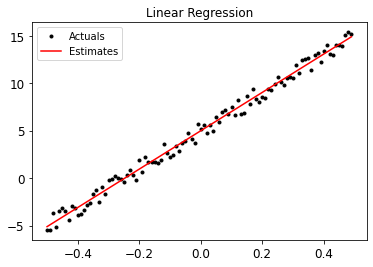

In [20]:
# 예측치
y_hat = [intercept + slope * x for x in X]

# 실제 데이터 분포
plt.plot(X, y, 'k.', label='Actuals')
# 예측치 그래프
plt.plot(X, y_hat, 'r-', label='Estimates')

plt.title("Linear Regression")
plt.legend()

plt.show()

## 5. 배치/미니배치/확률적 경사하강법

앞서 사용한 배치 경사하강법은 주어진 데이터셋 전체를 대상으로 평균제곱오차의 그레이디언트를 계산하였다.
이런 방식을 **배치 경사하강법**이라 부른다.

**주의**: 배치(batch)는 원래 하나의 묶음을 나타내지만 여기서는 주어진 (훈련) 데이터셋 전체를 가리키는
의미로 사용된다.

그런데 사용된 데이터셋의 크기가 100이었기 때문에 계산이 별로 오래 걸리지 않았지만,
데이터셋이 커지면 그러한 계산이 매우 오래 걸릴 수 있다.
실전에서 사용되는 데이터셋의 크기는 몇 만에서 수십억까지 다양하며, 
그런 경우에 적절한 학습률을 찾는 과정이 매우 오래 걸릴 수 있다.

데이터셋이 매우 큰 경우에는 따라서 아래 두 가지 방식 중 하나를 사용할 것을 추천한다.

* 미니배치 경사하강법
* 확률적 경사하강법

### 미니배치 경사하강법

미니매치 경사하강법(mini-batch gradient descent)은
전체 훈련 세트를 쪼갠 여러 개의 미니배치(작은 훈련 세트)에 대해 평균제곱오차의 그레이디언트를
계산하여 $\theta_0, \theta_1, \dots $ 를 업데이트한다. 

예를 들어, 전체 데이터셋의 크기가 1000이고 미니배치의 크기를 10이라 하면,
배치 경사하강법에서는 하나의 에포크를 돌 때마다 한 번 MSE와 그레이디언트를 계산하였지만
미니배치 경사하강법에서는 10개의 데이터를 확인할 때마다 MSE와 그레이디언트를 계산한다.
즉,하나의 에포크를 돌 때마다 총 100번 기울기와 절편을 업데이트한다. 

아래 코드에서 정의된 `minibatches()` 함수는 호출될 때마다
`batch_size`로 지정된 크기의 데이터 세트를 전체 데이터셋에서
선택해서 내준다.

데이터를 선택하는 방식은 다음과 같다.

* `minibatches()`: 호출될 때마다 `batch_size` 크기 만큼의 훈련 데이터를 생성해서 제공하는 제너레이터이다.
* `batch_starts`: 전체 데이터셋에서 차례대로 선택할 인덱스로 이루어진 어레이.
* 섞기(`shuffle`) 옵션: `batch_starts`에 포함된 항목들의 순서를 무작위로 섞을 때 사용.

In [21]:
from typing import List, Iterator

# 제너레이터 함수 정의
def minibatches(dataset: List[float],
                batch_size: int,
                shuffle: bool = True) -> Iterator[List[float]]:
    """
    dataset: 전체 데이터셋
    batch_size: 미니배치 크기
    shuffle: 섞기 옵션
    리턴값: 이터레이터
    """

    # 0번 인덱스부터 시작하여, batch_size 배수 번째에 해당하는 인덱스만 선택
    batch_starts = [start for start in range(0, len(dataset), batch_size)]
    
    # shuffle 옵션이 참이면 인덱스 섞기
    if shuffle: random.shuffle(batch_starts)

    # batch_starts에  포함된 인덱스를 기준으로 해서 미니배치 크기만큼씩 선택해서 
    # 다음 MSE와 그레이디언트 계산에 필요한 훈련 데이터 세트를 지정함.
    for start in batch_starts:
        end = start + batch_size
        yield dataset[start:end]

이제 미니배치 경사하강법을 이전에 사용했던 데이터에 대해 적용한다.
학습률(`learning_rate`)을 0.001로 하면 학습이 제대로 이루어지지 않는다.
에포크 수를 키우거나 합습률을 크게 해야 한다.

In [22]:
# 임의의 기울기와 절편으로 시작
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

# 학습률 지정
learning_rate = 0.001

# 1000번의 에포크
for epoch in range(1000):
    # 미니배치의 크기를 20으로 지정함
    # 따라서 한 번의 에포크마다 5번 MSE와 그레이디언트 계산 후 기울기와 절편 업데이트
    
    for batch in minibatches(inputs, batch_size=20):
        grad = LA.vector_mean([linear_gradient(x, y_x, theta) for x, y_x in batch])
        theta = gradient_step(theta, grad, learning_rate)

    # 100개의 에포크가 지날 때마다 학습 내용 출력
    if epoch % 100 == 0:
        print(epoch, theta)

intercept, slope = theta

print(f"최종 기울기: {slope:.3f}")
print(f"최종 절편: {intercept:.3f}")

0 [-0.14700601161032584, -0.850324957636322]
100 [3.0383003005334195, 0.81879593562066]
200 [4.21458258079334, 2.363808765349366]
300 [4.65037766647808, 3.7887387104243513]
400 [4.814916905651929, 5.100937311842601]
500 [4.880054707558669, 6.308581062740375]
600 [4.906941797916403, 7.419765388918784]
700 [4.921300749140654, 8.442074919728974]
800 [4.928451522266928, 9.382601070352939]
900 [4.934261548296817, 10.247863490712117]
최종 기울기: 11.036
최종 절편: 4.939


학습률을 0.01로 키우면 좋은 결과가 나온다.

In [23]:
# 임의의 기울기와 절편으로 시작
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

# 학습률 지정
learning_rate = 0.01

# 1000번의 에포크
for epoch in range(1000):
    # 미니배치의 크기를 20으로 지정함
    # 따라서 한 번의 에포크마다 5번 MSE와 그레이디언트 계산 후 기울기와 절편 업데이트

    for batch in minibatches(inputs, batch_size=20):
        grad = LA.vector_mean([linear_gradient(x, y_x, theta) for x, y_x in batch])
        theta = gradient_step(theta, grad, learning_rate)
    
    # 100개의 에포크가 지날 때마다 학습 내용 출력
    if epoch % 100 == 0:
        print(epoch, theta)

intercept, slope = theta

print(f"최종 기울기: {slope:.3f}")
print(f"최종 절편: {intercept:.3f}")

0 [1.237825277922001, 0.7249192271332124]
100 [4.952368308578804, 11.798388090708]
200 [4.970608256534244, 16.578080917985734]
300 [4.983392717759511, 18.637033407981054]
400 [4.986056813379833, 19.523825735584676]
500 [4.987595092175629, 19.90597277649338]
600 [4.988266095521663, 20.070316968833907]
700 [4.989040195003638, 20.14103697686222]
800 [4.989672228772879, 20.17161547560229]
900 [4.988703699118148, 20.184765698131514]
최종 기울기: 20.190
최종 절편: 4.989


학습률을 0.01로 두고 에포크를 3000으로 늘려도 성능이 그렇게 좋아지지 않는다.

In [24]:
# 임의의 기울기와 절편으로 시작
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

# 학습률 지정
learning_rate = 0.01

# 1000번의 에포크
for epoch in range(3000):
    # 미니배치의 크기를 20으로 지정함
    # 따라서 한 번의 에포크마다 5번 MSE와 그레이디언트 계산 후 기울기와 절편 업데이트
    
    for batch in minibatches(inputs, batch_size=20):
        grad = LA.vector_mean([linear_gradient(x, y_x, theta) for x, y_x in batch])
        theta = gradient_step(theta, grad, learning_rate)
    
    # 100개의 에포크가 지날 때마다 학습 내용 출력
    if epoch % 300 == 0:
        print(epoch, theta)

intercept, slope = theta

print(f"최종 기울기: {slope:.3f}")
print(f"최종 절편: {intercept:.3f}")

0 [-0.43549987222961334, 0.26254473969499653]
300 [4.978902536543744, 18.599116202912136]
600 [4.988010821486811, 20.067010548132913]
900 [4.989101560704833, 20.18451199354063]
1200 [4.989313445216165, 20.193984886037637]
1500 [4.98927937941379, 20.195015565259936]
1800 [4.988570103335046, 20.195105271575724]
2100 [4.989706094445955, 20.194956727051277]
2400 [4.990361301352804, 20.194971623699445]
2700 [4.989683544148361, 20.19504893855309]
최종 기울기: 20.194
최종 절편: 4.989


학습 과정을 살펴보면 기울기가 20.195 정도에서 더 이상 좋아지지 않는다.
이런 경우 특별히 더 좋은 결과를 얻을 수 없다는 것을 의미한다.
사실, 데이터셋을 지정할 때 가우시안 잡음을 추가하였기에 완벽한 선형함수를 찾는 것은 애초부터 불가능하다.
따라서 위 결과를 미니배치 경사하강법을 사용한 선형회귀로 얻을 수 있는 최선으로 볼 수 있다.

### 확률적 경사하강법(SGD)

확률적 경사하강법(stochastic gradient descent, SGD)은
미니배치의 크기가 1인 미니배치 경사하강법을 가리킨다.
즉, 하나의 데이터를 학습할 때마다 그레이디언트를 계산하여 기울기와 절편을 업데이트 한다. 

아래 코드는 주어진 데이터셋을 대상로 SGD를 적용하는 방식을 보여준다.
학습률을 0.001로 했음에도 불구하여 1000번의 에포크를 반복한 후에 이전에
0.01을 사용했던 경우와 거의 동일한 결과를 얻는다는 것을 확인할 수 있다.

In [25]:
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

# 학습률
learning_rate = 0.001

# 에포크는 1000
for epoch in range(1000):
    
    # 매 훈련 샘플에 대해 예측값을 확인한 후 바로 theta 값 업데이트
    for x, y_x in inputs:
        grad = linear_gradient(x, y_x, theta)
        theta = gradient_step(theta, grad, learning_rate)
    
    if epoch % 100 == 0:
        print(epoch, theta)

intercept, slope = theta

print(f"최종 기울기: {slope:.3f}")
print(f"최종 절편: {intercept:.3f}")

0 [0.550382182232026, 0.9895536437047407]
100 [5.032490886155949, 16.554658325069674]
200 [4.997519092010245, 19.51236265820966]
300 [4.990918695543546, 20.070584404084553]
400 [4.989672971014022, 20.175940275546683]
500 [4.9894378594398585, 20.19582459523417]
600 [4.9893934857031255, 20.19957745840122]
700 [4.989385110834649, 20.20028575429328]
800 [4.989383530205495, 20.200419434379114]
900 [4.989383231885758, 20.20044466446389]
최종 기울기: 20.200
최종 절편: 4.989


학습률을 0.01로 하면 결과가 오히려 좀 더 나빠진다.

In [26]:
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

# 학습률
learning_rate = 0.01

# 에포크는 1000
for epoch in range(1000):
    for x, y_x in inputs:
        grad = linear_gradient(x, y_x, theta)
        theta = gradient_step(theta, grad, learning_rate)
    if epoch % 100 == 0:
        print(epoch, theta)

intercept, slope = theta

print(f"최종 기울기: {slope:.3f}")
print(f"최종 절편: {intercept:.3f}")

0 [6.8116974087303825, 2.3020744483619793]
100 [4.990193170861476, 20.26103005086055]
200 [4.990192825899716, 20.26103222379059]
300 [4.990192825899663, 20.26103222379092]
400 [4.990192825899663, 20.26103222379092]
500 [4.990192825899663, 20.26103222379092]
600 [4.990192825899663, 20.26103222379092]
700 [4.990192825899663, 20.26103222379092]
800 [4.990192825899663, 20.26103222379092]
900 [4.990192825899663, 20.26103222379092]
최종 기울기: 20.261
최종 절편: 4.990


### 경사하강법 비교

앞서 살펴본 것에 따르면 확률적 경사하강법의 성능이 가장 좋았다.
하지만 이것은 경우에 따라 다르다.
아래 그림은 각각의 방식에서 절편과 기울기가 학습되는 과정을 잘 보여준다.

- 배치학습: 수렴값에 진동 없이 가장 빠르게 접근.
- 미니배치 학습: 중간 속도로 접근함. 수렴값 근처에서 진동이 어느 정도 있음.
- 확률적 경사 하강법: 매우 변화가 심함. 극한값 근처에서 여전히 진동이 매우 심함.

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/pydata/master/notebooks/images/gradient_descent_comparison.png" width="500"/></div>

## 사이킷런의 확률적 경사하강법 모델 

In [27]:
from sklearn import linear_model

linreg_sgd = linear_model.SGDRegressor()

사이킷런의 머신러닝 모델은 기본적으로 훈련 세트를 2차원 어레이로 요구하기에
아래처럼 먼저 차원을 추가한다.

__주의사항:__ 타깃 어레이 `y`는 1차원 어레이어야 한다.

In [28]:
X = np.c_[X]
y = np.array(y)

사이킷런 모델의 훈련방법은 `fit()` 메서드를 호출하는 방식으로 이루어진다.

In [29]:
linreg_sgd.fit(X, y)

SGDRegressor()

훈련결과로 찾아낸 선형회귀 모델의 절편과 기울기는 다음과 같다.

In [30]:
t0, t1 = linreg_sgd.intercept_[0], linreg_sgd.coef_[0]

print(f"절편:\t {t0}")
print(f"기울기:\t {t1}")

절편:	 4.982221986296401
기울기:	 18.840822703467992


기울기에 대한 훈련이 부족해보인다. 
확률적 경사하강법을 사용하기에 수렴값 근처에서 많은 진동이 발생할 수 있기에 학습률을 보다 작게 해보자.

* `eta0`: 학습률 기정. 기본값은 0.01임.

아래 코드는 학습률을 0.001로 지정한 후에 훈련한다.

In [31]:
linreg_sgd_1 = linear_model.SGDRegressor(eta0=0.001)
linreg_sgd_1.fit(X, y)

t0, t1 = linreg_sgd_1.intercept_[0], linreg_sgd_1.coef_[0]

print(f"절편:\t {t0}")
print(f"기울기:\t {t1}")

절편:	 4.927561524163672
기울기:	 9.365537800747957


/Users/gslee/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1208: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


기울기가 훨씬 덜 학습된 것으로 보인다. 즉, 학습률이 너무 적다.
그리고 경고창에서 알 수 있듯이 반복 훈련이 덜 되었다. 반복훈련의 기본값은 1,000번이다.
이를 5,000번으로 올려보자. 

* `max_iter`: 반복훈련 횟수 지정. 기본값은 1,000.

In [32]:
linreg_sgd_1 = linear_model.SGDRegressor(eta0=0.001, max_iter=5000)
linreg_sgd_1.fit(X, y)

t0, t1 = linreg_sgd_1.intercept_[0], linreg_sgd_1.coef_[0]

print(f"절편:\t {t0}")
print(f"기울기:\t {t1}")

절편:	 4.95832372425737
기울기:	 14.503989381717352


경고는 발생하지 않지만 여전히 훈련이 덜 되어 있다. 아무래도 반복횟수의 문제는 아닌 것 같다.
실제로 반복횟수를 50,000으로 올려도 별 변화가 없다.

In [33]:
linreg_sgd_1 = linear_model.SGDRegressor(eta0=0.001, max_iter=50000)
linreg_sgd_1.fit(X, y)

t0, t1 = linreg_sgd_1.intercept_[0], linreg_sgd_1.coef_[0]

print(f"절편:\t {t0}")
print(f"기울기:\t {t1}")

절편:	 4.95823344002572
기울기:	 14.50321304652143


결론적으로 학습률 0.001이 너무 작다. 따라서 학습률을 기본값인 0.01보다 좀 더 크게 해보자.
아래 코드는 0.03을 학습률로 사용한다.

In [34]:
linreg_sgd_1 = linear_model.SGDRegressor(eta0=0.03)
linreg_sgd_1.fit(X, y)

t0, t1 = linreg_sgd_1.intercept_[0], linreg_sgd_1.coef_[0]

print(f"절편:\t {t0}")
print(f"기울기:\t {t1}")

절편:	 4.983589984969054
기울기:	 19.604285712686572


반복훈련 횟수를 늘려도 별 변화가 없다.
앞서 언급한 대로 확률적 경사하강법은 수렴값 근처에서 심하게 진동하기 때문이다. 

In [35]:
linreg_sgd_1 = linear_model.SGDRegressor(eta0=0.03, max_iter=10000)
linreg_sgd_1.fit(X, y)

t0, t1 = linreg_sgd_1.intercept_[0], linreg_sgd_1.coef_[0]

print(f"절편:\t {t0}")
print(f"기울기:\t {t1}")

절편:	 4.985259928226336
기울기:	 19.597986815558308


## 연습문제

넘파이 어레이를 활용하여 선형회귀 모델을 배치 경사하강법으로 구현하려 한다.
즉, 본문과는 달리 어레이 메서드를 다양하게 활용해야 한다.

먼저, 아래 코드는 100개의 샘플을 임의로 생성한다.

In [36]:
X = 2 * np.random.rand(100)
y = 4 + 3 * X + np.random.randn(100) 

### 문제 1

산점도를 그리는 코드를 완성하라.

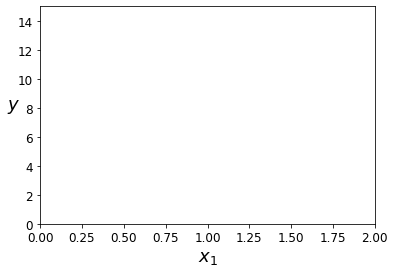

In [37]:
# pass 부분을 적절한 코드로 대체하라.

pass

plt.xlabel("$x_1$", fontsize=18)             
plt.ylabel("$y$", rotation=0, fontsize=18)   
plt.axis([0, 2, 0, 15])                      
plt.show()

`gradient_step()` 함수는 매 에포크마다
절편과 기울기를 
그레이디언트를 이용하여 지정된 학습율의 비율만큼 업데이트 한다.
넘파이 어레이를 활용한 연산임에 주의해야 한다. 

In [38]:
def gradient_step(v, gradient, learning_rate):
    step = gradient*learning_rate
    new_V = v - step

    return new_V

### 문제 2

`linear_gradient()` 함수가 매 에포크마다 그레이디언트를 
계산하도록 아래 코드를 완성하라.
단, 넘파이 어레이와 관련된 함수를 이용해야 한다.

In [39]:
# pass와 None 각각을 적절한 코드와 값으로 대체하라.
def linear_gradient(X, y, theta):
    
    intercept, slope = theta[0], theta[1]           
    predicted = intercept + slope * X  
    error = (predicted - y) 
    pass

    return None

### 문제 3

배치 경사하강법으로 선형회귀 모델의 절편과 기울기를 구하는 코드를 작성하라.

In [40]:
# pass문을 적절한 코드로 대체하여 배치 경사하강법을 구현하라.

theta = np.random.uniform(-1, 1, 2)

pass

### 문제 4

학습률과 에포크를 어느 정도로 하는 것이 적당해 보이는가?

### 문제 5

데이터셋 `X`와 `y`에 대해 미니배치 경사하강법을 이용하여 선형회귀 모델의 절편과 기울기를 구하라.

In [41]:
# pass문을 적절한 코드로 대체하여 미니배치 경사하강법을 구현하라.

theta = np.random.uniform(-1, 1, 2)

pass

### 문제 6

데이터셋 `X`와 `y`에 대해 확률적 경사하강법을 이용하여 선형회귀 모델의 절편과 기울기를 구하라.

In [42]:
# pass문을 적절한 코드로 대체하여 확률적 경사하강법을 구현하라.

theta = np.random.uniform(-1, 1, 2)

pass